In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [57]:
forex_data = pd.read_csv('data/EUR_USD Historical Data.csv')
forex_data.columns = forex_data.columns.str.strip()
forex_data.rename(columns={'date': 'Date'}, inplace=True)
forex_data['Date'] = pd.to_datetime(forex_data['Date'])
forex_data = forex_data.drop(columns=['Vol.','Change %'])

forex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    258 non-null    datetime64[ns]
 1   Price   258 non-null    float64       
 2   Open    258 non-null    float64       
 3   High    258 non-null    float64       
 4   Low     258 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 10.2 KB


In [58]:
close_data = forex_data.filter(['High','Low'])
df = close_data.values
train_size = int(np.ceil(len(df) * 1))
train_size

258

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_input = scaler.fit_transform(df) 

train_data = scaled_data_input[0: int(train_size), :]

x_train = []
y_train = []

for i in range(1, len(train_data)):
    x_train.append(train_data[i-1:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape,y_train.shape

((257, 1, 1), (257,))

In [60]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model.add(BatchNormalization())
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.fit(x_train, y_train)

c:\Users\rnmpr\Documents\project n sample\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2930 - mae: 0.4877


In [61]:
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0664 - mae: 0.2168 
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0546 - mae: 0.1866 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - mae: 0.1056 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 - mae: 0.1011 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - mae: 0.0922 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mae: 0.0799 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - mae: 0.0804 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - mae: 0.0827 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0700 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mae: 0.0723 


In [62]:
model.save('model_1.keras')

In [63]:
print("\ninitial mae {} | latest mae: {}".format(history.history["mae"][0], history.history["mae"][-1]))
print("initial loss: {} | latest loss: {}".format(history.history["loss"][0], history.history["loss"][-1]))


initial mae 0.20686905086040497 | latest mae: 0.07041635364294052
initial loss: 0.061914145946502686 | latest loss: 0.008410452865064144


### model 1

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("model_1.keras")

# Load new data for predictions
new_data = pd.read_csv("data/EUR_USD Historical Data.csv")
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data.set_index('Date', inplace=True)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data[['High', 'Low']].values)

# Prepare data for prediction# Sliding window size
lookback = 1
X_pred = [scaled_data[i-lookback:i, 0] for i in range(lookback, len(scaled_data))]
X_pred = np.array(X_pred).reshape(len(X_pred), lookback, 1)

# Predict
# Predict
try:
    predictions = model.predict(X_pred)
except ValueError as e:
    print("Error during prediction:", e)

# Ensure model output matches scaler input for inverse transformation
if predictions.shape[1] != scaled_data.shape[1]:
    print(f"Model predictions ({predictions.shape}) do not match scaler input shape ({scaled_data.shape}).")
    # Handle single-column predictions by creating a placeholder
    predictions = np.hstack([predictions, np.zeros((predictions.shape[0], 1))])

# Inverse transform predictions
predicted_prices = scaler.inverse_transform(predictions[:, :scaled_data.shape[1]])


# Save predictions
prediction_dates = new_data.index[lookback:]
# Ensure matching lengths
min_length = min(len(prediction_dates), len(predicted_prices))
prediction_dates = prediction_dates[:min_length]
predicted_prices = predicted_prices[:min_length]

# Create DataFrame
results = pd.DataFrame({
    "Date": pd.to_datetime(prediction_dates).strftime('%m-%d-%Y'),
    "Predicted_High": predicted_prices[:, 0].round(4),
    "Predicted_Low": predicted_prices[:, 1].round(4)
})
results.to_csv('predicted_price_1.csv', index=False)
print("Predictions saved to 'predicted_price_1.csv'")



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Model predictions ((257, 1)) do not match scaler input shape ((258, 2)).
Predictions saved to 'predicted_price_1.csv'


In [65]:
print("Scaled Data Shape:", scaled_data_input.shape)
print("Scaled Data Shape:", scaled_data.shape)
print("Predictions Shape:", predicted_prices.shape)

Scaled Data Shape: (258, 2)
Scaled Data Shape: (258, 2)
Predictions Shape: (257, 2)


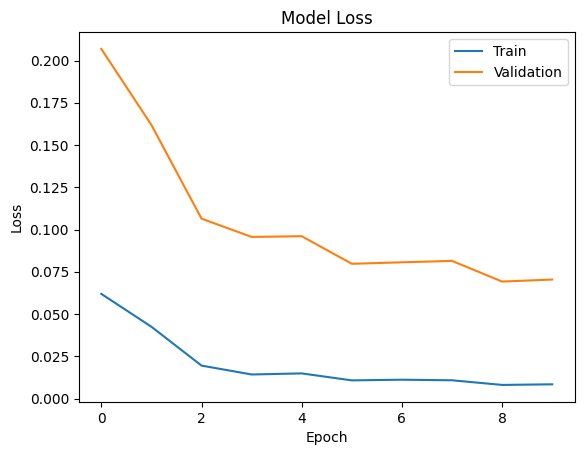

In [66]:
import matplotlib.pyplot as plt

# Assuming `history` is the history object returned by the `fit` method
# It contains the loss and any other metrics you have specified

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
